## TP3 : Logistic regression

The purpose of this tutorial is to implement and use the Logistic Regression for binary classification. We will apply this
method to the problem of handwritten characters to learn how to
distinguish two numbers (here 5 and 6).


In [57]:
from pylab import *
import numpy as np
#import matplotlib.pyplot as plt

from numpy import linalg as la

In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 8)

Populating the interactive namespace from numpy and matplotlib


/home/kronert/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['power', 'random', 'fft', 'info', 'linalg']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 1. Logistic regression, IRLS algorithm.

### Preliminary question: the algorithm

#### Have a look at the function `regression_logistique.m` and locate the main steps of the algorithm you have been taught (see course).
You can comment the code in the cell below.

In [3]:
def regression_logistique(X,t,Nitermax=20,eps_conv=1e-3):
    '''Entrees :
    X = [ones(N_train,1) x_train];
    t = class_train 
    Nitermax = nombre maximale d'itérations (20 par défaut)
    eps_conv = critère de convergence sur norm(w-w_old)/norm(w) ; 
    eps_conv=1e-3 par défaut
    
    Sorties : 
    w : vecteur des coefficients de régression logistique
   Niter : nombre d'itérations utilisées effectivement
   
   Fonction de régression logistique pour la classification binaire.
   
   Utilisation :
       Nitermax = 50
       eps_conv = 1e-4
       [w,Niter] = regression_logistique(X,t,Nitermax,eps_conv)
    '''
    N_train = X.shape[0]

    #initialisation : 1 pas de l'algorithme IRLS
    w = np.zeros((X.shape[1],))
    w_old = w 
    y = 1/2*np.ones((N_train,)) # sigma(0) = 1/2
    R = np.diag(y*(1-y))   # diag(y_n(1-y_n))
    z = X.dot(w_old)-la.inv(R).dot(y-t)
    w = la.inv(X.T.dot(R).dot(X)).dot(X.T).dot(R).dot(z)

    # boucle appliquant l'algortihme de Newton-Raphson
    Niter = 1
    while ( (la.norm(w-w_old)/la.norm(w)>eps_conv) & (Niter<Nitermax) ):
        Niter = Niter+1
        y = 1/(1+np.exp(-X.dot(w)))
        R = np.diag(y*(1-y))  # Matrice Hessienne de la fonction coût
        w_old = w 
        # Newton Raphton
        z = X.dot(w_old)-la.inv(R).dot(y-t) 
        w = la.inv(X.T.dot(R).dot(X)).dot(X.T).dot(R).dot(z)
         
    return w, Niter


### Reading & preparing synthetic data

Load the training and test data sets `synth_train.txt`
and `synth_test.txt`. The targets t belong to {1,2} and the features  
x belong to R^2. 

We have 100 training samples and 200 test samples

* the 1st column contains the label of each sample, 
* columns 2 and 3 contain the coordinate of each point.

In [4]:
# Training set
synth_train = np.loadtxt('synth_train.txt') 
class_train = synth_train[:,0]
class_train_1 = np.where(synth_train[:,0]==1)[0]
class_train_2 = np.where(synth_train[:,0]==2)[0]
x_train = synth_train[:,1:]
N_train = np.size(x_train,axis=0)

# Test set
synth_test = np.loadtxt('synth_test.txt')
class_test = synth_test[:,0]
class_test_1 = np.where(synth_test[:,0]==1)[0]
class_test_2 = np.where(synth_test[:,0]==2)[0]
x_test = synth_test[:,1:]
N_test = np.size(x_test,axis=0)


### Preparing features for logistic regression (binary classification)
First, we prepare the feature matrix and the target vector associated to 
the training and test sets:


In [81]:
X = np.hstack((np.ones((N_train,1)),x_train))
t = 2-class_train   # 0 if class=2, 1 if class=1

X_test = np.hstack((np.ones((N_test,1)),x_test))
t_test = 2-class_test   # 0 if class=2, 1 if class=1

### Exercise 1 : the logistic function of decision

1. Use the function `regression_logistique.m` to estimate the logistic
regression vector `w`. *Indication : use `Nitermax = 50;
eps_conv=1e-3;`.*
2. Compute the decision function $f(x) = argmax_k P(C_k|x)$ on the test set
to get the classification results. Recall that $y_n=\sigma(w^T x)$ (logistic function)
and that *using vectors* you may directly write $y=\sigma(Xw)$, with the
column of ones in X.
3. Display the results by plotting the points from both the training set
and the test set.
4. Write the equation which defines the decision boundary.
5. Artificially add a few points to the training set far from the decision boundary to check the robustness of logistic regression to outliers. Check the behaviour of LDA for comparison in this case and comment. 


## Functions tools

In [82]:
add_quadratic = lambda X : hstack((ones((X.shape[0],1)),X,X**2,(X[:,0]*X[:,1]).reshape((-1,1))))
add_one = lambda X : hstack((ones((X.shape[0],1)),X))

def sigma(x):
    """
    Compute the sigmoid value of x
    parameters : 
        - x a float
    return :
        - 1/(1+exp(-x))
    """
    return 1/(1 + np.exp(-x))

def afficher_grille(w,quad=False):
    """
    plot the decision bondary 
    parameters :
        - w the parameters of the logistic regression
    """
    x_1 = linspace(-2.5,1,500)
    x_2 = linspace(0,4,500)
    [X1,X2] = meshgrid(x_1,x_2)
    grid = c_[X1.ravel(),X2.ravel()]
    G = add_quadratic(grid) if quad else add_one(grid)
    G_test = (sigma(w.dot(G.T))>0.5)
    contourf(X1,X2,G_test.reshape(X1.shape))

def afficher_inferrence(x,y):
    """ plot the result of an prediction
    parameters :
        - x the features
        - y the labels"""
    plot(x[y==1][:,0],x[y==1][:,1],'yo')
    plot(x[y==0][:,0],x[y==0][:,1],'bo')

def afficher_precision(y,t):
    """
    compute the errors rate 
    parameters :
        - y predicted labels 
        - t real labels
    """
    print(f"Taux d'erreur {100*(y!=t).sum()/y.shape[0]}%")

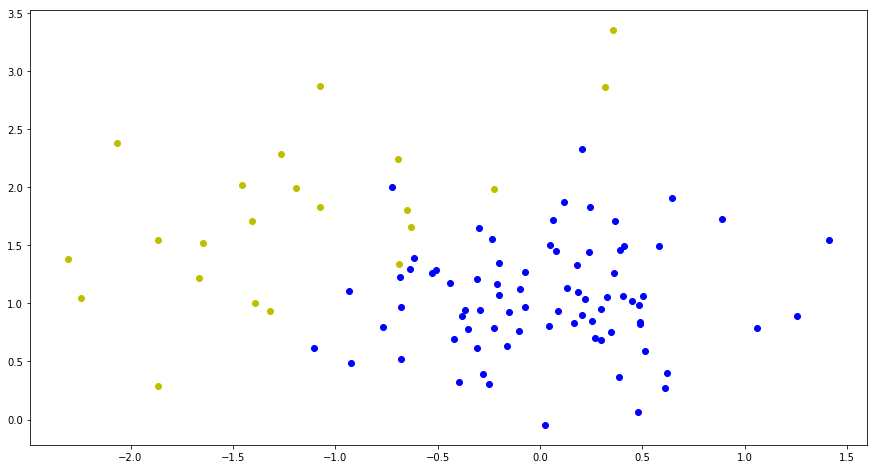

In [83]:
afficher_inferrence(x_train, t)

Taux d'erreur 6.0%


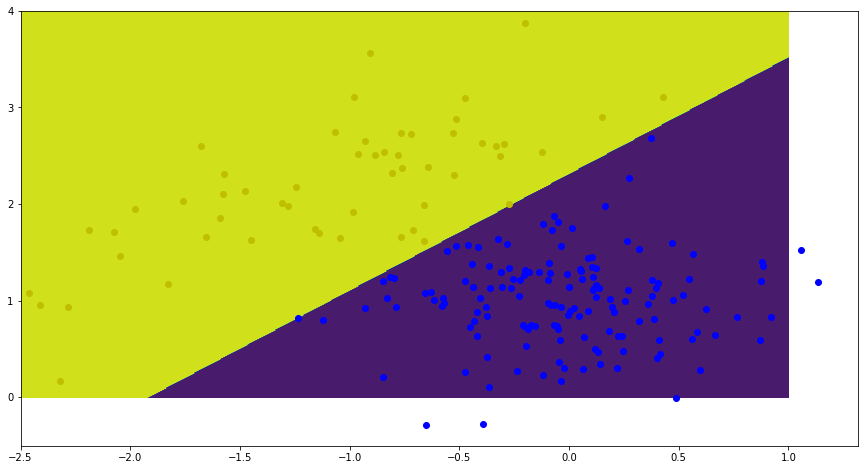

In [84]:
#Exercise 1
w, Niter = regression_logistique(X, t)



y_test = (sigma(w.dot(X_test.T))>0.5)
afficher_inferrence(x_test,y_test)
afficher_precision(y_test,t_test)
afficher_grille(w)

You can draw the decision boundary $w^Tx = 0$ by using: 


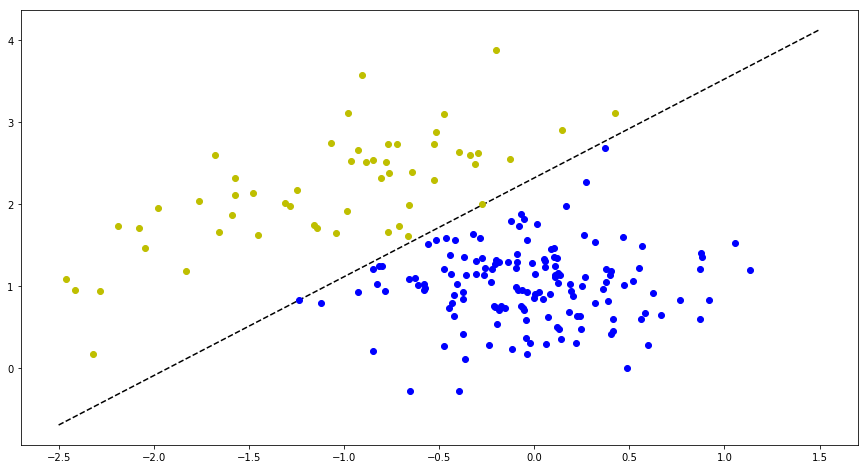

In [85]:
# First compute w... then: 
x1 = np.linspace(-2.5,1.5,10) 
x2 = (-w[0]-w[1]*x1)/w[2]
plt.plot(x1,x2,'k--')
# ...
afficher_inferrence(x_test,y_test)


In [89]:
# we add the quadratics features
Xq = add_quadratic(x_train)
# we compute the parameters of the logistic regression
w, Niter = regression_logistique(Xq, t)
# we add the quadratics features
X_test = add_quadratic(x_test)

# prediction with the fitted model
y_test = (sigma(w.dot(X_test.T))>0.5)

Taux d'erreur 5.5%


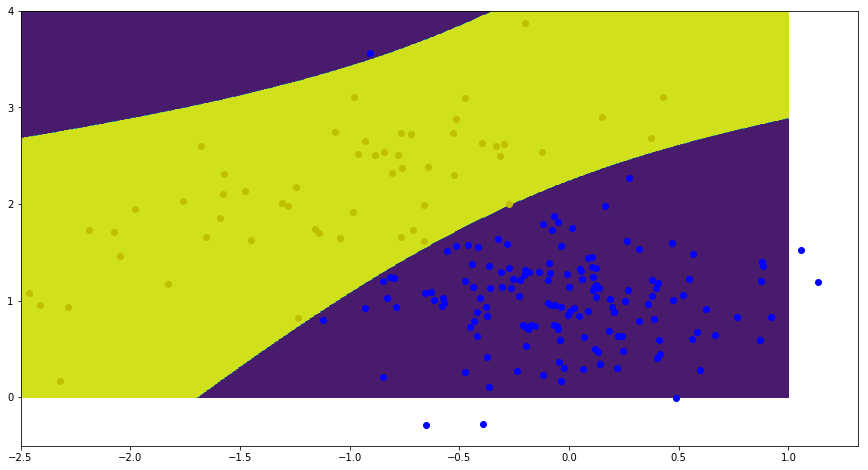

In [90]:
afficher_inferrence(x_test,y_test)
afficher_grille(w,quad=True)
afficher_precision(y_test,t_test)

## 2. Application: handwritten digits recognition 5 & 6
We load 2 matrices which contain each a sequence of examples of 16x16 images 
of handwritten digits which are 5 and 6 here. Each line of the matrix
contains 256 pixel values coding for the gray level of a 16x16 image.

In [94]:
train_5 = np.loadtxt('train_5.txt',delimiter=',')   # 556 samples
train_6 = np.loadtxt('train_6.txt',delimiter=',')   # 664 samples

### Examples of images


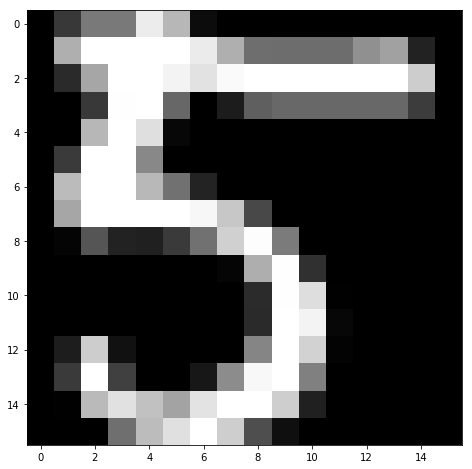

In [95]:
# Digit 5
n=9;
I = np.reshape(train_5[n,:],(16,16))

plt.imshow(I,cmap='gray')
plt.show()

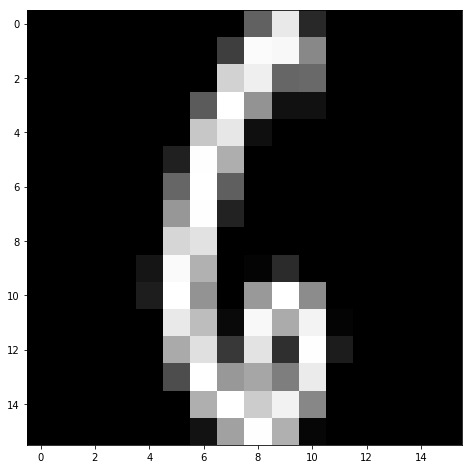

In [96]:
# Digit 6
n=5;
I = reshape(train_6[n,:],(16,16))

plt.imshow(I,cmap='gray')
plt.show()

### Separating the training and test sets

We keep in the training set the 145 first images of 5s and the 200 first
images of 6s:


In [ ]:
x_train_brut = np.vstack((train_5[:145,:], train_6[:200,:]))
N_train = np.size(x_train_brut,axis=0)
class_train = np.ones((345,1))   # label 1 for digit 6
class_train[:145] = 0       # label 0 for digit 5

x_test_brut = np.vstack((train_5[145:,:], train_6[200:,:]))
N_test = np.size(train_5,axis=0)+np.size(train_6,axis=0)-N_train

## Exercise 2: logistic regression to classify 5 & 6

1. Note that pixel values are between -1 and 1 by using the functions
 `min(I(:))` and `max(I(:))`.
2. Identify the indices of the most significant pixels, which are defined 
as having a standard deviation greater than 0.5 here. We denote by `lis_sig`
the list of positions of these significant pixels in the image vector.
_Indication : the function `std` gives the standard deviation (columnwise
in matrices) and you should find 173 pixel positions.
3. Show a binary image to locate these pixels.
_Indication : `Isig = zeros(16); Isig(list_sig)=1; Isig=Isig';`._
4. Define the training set `x_train` from `x_train_brut` from the significant pixels only.
5. Do the same with `x_test_brut` to extract `x_test`.
6. Use `regression_logistique.m` to estimate the logistic regression vector
`w` from the training set `x_train`. 
Choose `Nitermax = 13; eps_conv = 1e-3;`
7. Compute the decision function and the labels of the test set `x_test`. 
_Indication : do not forget the column of ones !_
8. Estimate the classification error rate by using :
`erreur = sum(abs(class-class_test))/N_test;`.
9. Locate some misclassified examples and visualize the corresponding image.
Comment on your results and observations.


In [ ]:
# Exercise 2

## 3. Logistic regression using `scikit-learn`

1. **Go to** http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html for a presentation of the logistic regression model in `scikit-learn`.

2. **Apply** it to the present data set.

3. **Comment** on the use of logistic regression.

*Indication : you may have a look at* 

a) Theory : http://openclassroom.stanford.edu/MainFolder/DocumentPage.php?course=MachineLearning&doc=exercises/ex5/ex5.html

b) Video :  https://www.coursera.org/learn/machine-learning/lecture/4BHEy/regularized-logistic-regression 

c) Example : http://scikit-learn.org/stable/auto_examples/exercises/plot_digits_classification_exercise.html#sphx-glr-auto-examples-exercises-plot-digits-classification-exercise-py

*for a short presentation of regularized logistic regression.*

In [ ]:
# Include your code here
from sklearn.linear_model import LogisticRegression
# ...


Commentaires :